<a href="https://colab.research.google.com/github/sturu1/THU-PM/blob/master/Copy_of_7_Time_Series_Problem_using_RNN_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##시계열 기반 예측 (Time-Series Prediction)

이번 실습은 아래의 내용을 일부 수정하여 진행합니다. 

*  원저자 Magnus Erik Hvass Pedersen (http://www.hvass-labs.org/)
* GitHub (https://github.com/HvassLabs/TensorFlow-Tutorials)
* Videos on YouTube (https://www.youtube.com/playlist?
list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ) 

 / 번역 곽병권

## 개요

이 튜토리얼은 복수의 여러 도시의 기후 정보를 이용하여 한 도시의 미래 날씨 예보를 시도합니다.
우리는 임의의 길이를 가진 일련의 데이터로 작업 할 것이기 때문에 RNN (Recurrent Neural Network)을 사용할 것입니다.
아래의 내용을 이해하기 위해서는 TensorFlow와 Keras에 익숙해야하며, 튜토리얼 #01과 #03-C, 튜토리얼 #20에서 설명
되어 있는 RNN의 기본 사항을 참고하면 좋습니다.

## 위치
여기에서는 1980년~2018년까지의 덴마크 Denmark (https://en.wikipedia.org/wiki/Denmark)에 있는 다섯개 도시의
기후 정보를 사용합니다:
* Aalborg (https://en.wikipedia.org/wiki/Aalborg) 이곳의 기후 정보는 실제로 공군기지에서 얻게되는데, 여기는 The Hunter Corps (Jægerkorps) (https://en.wikipedia.org/wiki/Jaeger_Corps_(Denmark)의 본거지 이기도 합니다.
* Aarhus (https://en.wikipedia.org/wiki/Aarhus) 이 도시는 C++ 발명자-비얀 스트롭스트룹(https://en.wikipedia.org/wiki/Bjarne_Stroustrup)가 연구했고 Google V8 JavaScript Engine(https://en.wikipedia.org/wiki/Chrome_V8)이 개발된 곳 입니다.
* Esbjerg (https://en.wikipedia.org/wiki/Esbjerg) 은 거대한 낚시 항구를 가지고 있습니다.
* Odense (https://en.wikipedia.org/wiki/Odense) 은 동화작가인 안데르센_H. C. Andersen(https://en.wikipedia.org/wiki/Hans_Christian_Andersen)이 태어난 도시입니다.
* Roskilde (https://en.wikipedia.org/wiki/Roskilde) 에는 덴마크 왕가의 무덤이 있는 오래된 성당이 있습니다.


아래의 지도는 덴마크에서 각각의 도시의 위치를 보여주고 있습니다

![Map of Denmark](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/Denmark.jpg?raw=1)

아래 지도에서 유럽내에서 덴마크의 위치를 확인할 수 있습니다:

![Map of Europe](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/Europe.jpg?raw=1)

## 흐름도
이 튜토리얼에서는 5개 도시의 현재 및 과거 기상 데이터를 바탕으로 향후 24시간 동안 덴마크 "Odense"지역 날씨를 예측하려고 합니다 (아래의 순서도는 2개 도시 만 표시 함).
우리는 임의의 길이를 가진 일련의 데이터로 작업을 해야 하기 때문에 RNN (Recurrent Neural Network)을 사용합니다. 학습 중 우리는 5개 도시 각각에 대해 **온도, 압력 등에 대한 20개의 입력 신호**가 있는 각 데이터 포인트 또는 관측값이 있는 학습세트에서 **1344데이터 포인트 (8주 = 24 x 7 X 8)의 하위 시퀀스**를 사용합니다. 우리는 신경 망을 학습시켜서 **내일의 온도, 압력 및 풍속에 대한 3가지 신호를 출력** 하도록 만들 것 입니다.

![Flowchart](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/23_time_series_flowchart.png?raw=1)

## Imports

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

Keras에서 다수의 클래스를 Import 합니다.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU #input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Load Data

아래의 코드는 덴마크의 다섯개 도시의 날씨 정보를 자동으로 다운로드 해 줍니다.
원시 날씨 데이터는 원래 [National Climatic Data Center (NCDC), USA] (https://www7.ncdc.noaa.gov/CDO/cdoselect.cmd)에서 (https://www7.ncdc.noaa.gov/CDO/cdoselect.cmd)에서) 가져온 것입니다. 웹 사이트 및 데이터베이스 액세스는 정리되어 있지는 않고 또 곧 변경될 여지가 있습니다. 또한 원시 데이터 파일을 읽어들이기 전에 수동으로 편집해야 했습니다. 따라서 다른 지역의 날씨 데이터를 다운로드 할 계획이 있다면 여러가지 난관이 있을 것을 대비하시기 바랍니다. 아래의 파이썬 모듈은 새로운 날씨 데이터를 사용하고자 하는 경우 유용 할수있는 기능을 제공하지만 데이터 형식에 맞게 소스 코드를 수정해야 합니다.

본 실습에서 Data는 저자의 github에서 가져오도록 하겠습니다. 다음 두 파일을 다운로드 하시기 바랍니다. 

`https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/weather.py`

`https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/download.py`

In [15]:
!wget https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/weather.py

!wget https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/download.py

--2020-08-06 05:42:21--  https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/weather.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8169 (8.0K) [text/plain]
Saving to: ‘weather.py’

weather.py          100%[===================>]   7.98K  --.-KB/s    in 0s      

2020-08-06 05:42:21 (90.1 MB/s) - ‘weather.py’ saved [8169/8169]

--2020-08-06 05:42:22--  https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4353 (4.3K) [text/plain]
Saving to

In [16]:
import weather

데이터를 다운로드 합니다. 만약 다운로드가 이미 되어 있다면 하지 않습니다. 크기는 35MB입니다.

In [19]:
weather.maybe_download_and_extract()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


데이터 세트에 사용된 도시 목록을 표시합니다.

In [20]:
cities = weather.cities
cities

['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']

데이터를 로드하고, 샘플링 간격을 60분 간격으로 조정합니다. 누락된 구간은 선형으로 보간합니다. 이것은 최초 실행에서는 약 30초가 걸리지만 캐시 파일을 사용하므로 한번만 실행됩니다.

In [21]:
%%time
df = weather.load_resampled_data()

CPU times: user 1min 34s, sys: 6.71 s, total: 1min 40s
Wall time: 1min 40s


다음은 가공된 데이터 세트의 상위 다섯개의 행을 표시합니다.

In [22]:
df.head()

Aalborg               ...   Roskilde            
                         Temp     Pressure  ...  WindSpeed     WindDir
DateTime                                    ...                       
1980-03-01 11:00:00  5.000000  1007.766667  ...  11.466667  280.000000
1980-03-01 12:00:00  5.000000  1008.000000  ...  12.466667  280.000000
1980-03-01 13:00:00  5.000000  1008.066667  ...  13.133333  278.333333
1980-03-01 14:00:00  4.333333  1008.133333  ...  12.300000  270.000000
1980-03-01 15:00:00  4.000000  1008.200000  ...  12.300000  270.000000

[5 rows x 20 columns]

## 누락된 데이터
Esbjerg와 Roskilde의 두 도시의 데이터에는 아래의 두개의 그래프에서 보이듯이 대기압 정보에 **일부 누락된 데이터**가 있습니다.여기에서는 리샘플링 된 데이터를 사용하기 때문에, 누락 된 값이 있는 경우 해당 구간을 인접 값에서 선형으로 보간 된 새 값으로 채 웁니다. 이 값은 그래프상에서는 긴 직선으로 나타납니다. 이것은 신경망을 혼동시킬 수 있습니다. 간단히 하기 위해서, 여기에서는 **이 두개의 컬럼을 삭제**합니다. 지금은 데이터 축을 삭제하고 진행하지만, 이 데이터 구간이 비교적 짧은 기간의 데이터 만 누락되어 있기 때문에, 다른 모든 입력 신호에서 누락 된 데이터를 생성하는 예측 모델을 만들어 이 데이터를 생성 할 수 있습니다. 그런 다음 생성 된 값을 데이터 세트에 다시 추가하여 간격을 채울 수 있습니다.

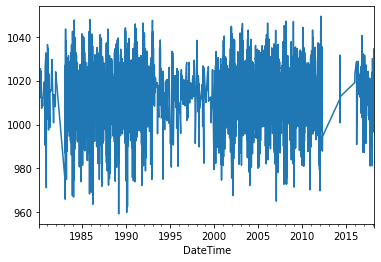

In [23]:
df['Esbjerg']['Pressure'].plot()

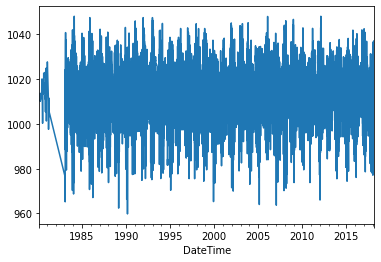

In [24]:
df['Roskilde']['Pressure'].plot()

이 두 신호를 제거하기 전에는 데이터 세트에 20 개의 입력 신호가 있었습니다.

In [25]:
df.values.shape

(333109, 20)

그런 다음 누락 된 데이터가 있는 두 개의 신호를 제거합니다.

In [28]:
df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)

이제는 데이터에 18개의 입력 신호만 있습니다.

In [29]:
df.values.shape

(333109, 18)

이 두 데이터 열이 실제로 제거되었는지 확인할 수 있습니다.

In [30]:
df.head()

Aalborg               ...   Roskilde            
                         Temp     Pressure  ...  WindSpeed     WindDir
DateTime                                    ...                       
1980-03-01 11:00:00  5.000000  1007.766667  ...  11.466667  280.000000
1980-03-01 12:00:00  5.000000  1008.000000  ...  12.466667  280.000000
1980-03-01 13:00:00  5.000000  1008.066667  ...  13.133333  278.333333
1980-03-01 14:00:00  4.333333  1008.133333  ...  12.300000  270.000000
1980-03-01 15:00:00  4.000000  1008.200000  ...  12.300000  270.000000

[5 rows x 18 columns]

## 데이터 오류
이 데이터에는 몇 가지 오류가 있습니다. 아래 그림에서 볼 수 있듯이 Odense시 온도가 갑자기 거의 50도까지 상승합니다. 하지만, 덴마크에서 측정된 최고 기온은 섭씨 36.4℃도 였고 최저치는 -31.2℃였습니다. 따라서 이것은 분명히 데이터 오류
로 볼 수 있습니다. 그렇지만, 이 자습서에서는 데이터 오류를 수정하지 않습니다.

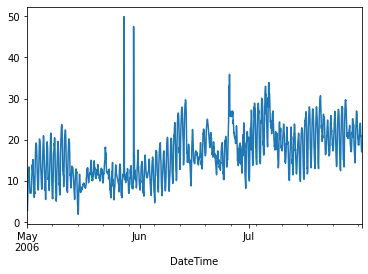

In [31]:
df['Odense']['Temp']['2006-05':'2006-07'].plot()

그 기간 동안 덴마크의 일부 다른 도시의 기온은 불과 10℃에 불과하다는 점을 감안하면 오류일 가능성이 매우 높습니다. 덴
마크의 면적을 고려할 때 다른 도시의 기온이 10℃인데, 한 도시가 50℃의 기온을 보이는 것은 불가능하기 때문입니다.

## 데이터 추가
우리는 모델이 예측을 하면서 도움을 받을 수 있도록 데이터에 몇 가지 입력 신호를 추가 할 수 있습니다. 예를 들어 섭씨 10℃의 온도만 주어지면 낮인지 밤인지 여름인지 겨울인지에 따른 온도 측정의 여부를 알 수 없습니다. 이 모델은 비정상적으로 따뜻한 겨울인지, 비정상적으로 추운 여름인지, 또는 주간인지 밤인지 여부를 판단하기에 매우 정확하지 않은 주변 데이터 포인트로부터 이를 추측해야 합니다. 따라서 이 정보를 가지고 있으면 모델이 얼마나 정확하게 다음 출력을
예측할 수 있는지에 큰 차이를 줄 수 있습니다. 데이터 세트에는 각 관측치에 대한 날짜 및 시간 정보가 포함되어 있지만 데이터를 정렬하기 위한 인덱스로만 사용됩니다. 따라서 우리는 일년 중 몇일째 인지(1 ~ 366)와 시간대(0 ~ 23)를 데이터 세트에 별도의 입력 신호로 추가 할 것 입니다.

## 예측을 위한 목표 데이터
우리는 이 도시의 미래 날씨 데이터를 예측 할 것입니다.

우리는 이러한 신호를 예측 할 것입니다.

다음은 목표 데이터를 교차 이동할 단계의 수입니다. 우리의 데이터 세트는 매 시간단위의 관찰값으로 재샘플링 되었으므로 24시간 동안 24번의 관찰값이 있습니다.


앞으로 24시간 동안 날씨를 예측하고 싶다면 24시간 간격으로 데이터를 교차 이동하십시오. 미래 7일 날씨를 예측하려면 7 * 24시간 간격으로 데이터를 이동하면 됩니다.

교차 이동을 통해서 새 데이터 프레임을 만듭니다.

**음수 교차 이동임을 주의**해서 보세요!

**주의! 올바른 방향으로 데이터를 이동했는지 다시 확인해야합니다! **

우리는 과거가 아니라 미래를 예측하고 싶습니다!
이동 한 데이터 프레임이 약간 혼동스러울 수 있습니다. 데이터를 이동했지만 Pandas는 원본 타임 스탬프는 유지하기 때문입니다. 원본 및 시간 이동 데이터 프레임을 비교하여 데이터 교차 이동이 제대로 이루어졌는지 확인할 수 있습니다.


이것은 원본 데이터 프레임의 첫 번째 shift_steps + 5 행입니다.

다음은 교차 이동된 데이터 프레임의 처음 5행 입니다. 이것은 시간을 제외하고는 원래 데이터에서 위에 표시된 마지막 5행과
동일해야 합니다.

교차 이동 된 데이터 프레임은 원래 데이터 프레임과 길이가 같지만, 데이터가 거꾸로 이동 했으므로 마지막 관측치는 NaN(숫자가 아님)이 됩니다. 왜냐하면 존재하지 않는 데이터를 역방향으로 교차 이동하려고 했기 때문입니다.

## NumPy 배열
지금 우리는 Pandas 데이터 프레임을 신경망에 입력 할 수 있는 NumPy 배열로 변환합니다. 또한 대상 데이터가 이동된 기간에 대해 **NaN값을 들어있기 때문에 numpy 배열의 마지막 부분을 제거하고 유효한 데이터만 유지**해야 하고 입력 및 출력 데이터에 대해 동일한 배열 모양이 필요합니다.

다음은 입력 신호입니다:

다음은 출력 신호 (또는 대상 신호)입니다:

이것은 데이터 세트의 관측 수 (일명 데이터 포인트 또는 샘플)입니다:

이것은 학습용 세트에 사용될 데이터 세트의 일부입니다:

이것은 학습용 세트의 관측수 입니다:

이것은 테스트 세트의 관측 수입니다:

다음은 학습 및 테스트 세트의 입력 신호입니다:

다음은 학습 및 테스트 세트의 출력신호 입니다:

이것은 입력 신호의 수 입니다:

이것은 출력 신호의 수 입니다:

## 데이터 정규화
데이터 세트에는 다음과 같은 다양한 값이 포함됩니다:

신경망은 대략 -1에서 1 사이의 값에서 가장 잘 작동하므로 데이터가 신경망에 입력되기 전에 데이터의 값의 범위를 조정해야 합니다. 우리는 scikit-learn을 사용할 수 있습니다.

먼저 입력 신호용 스케일러 객체를 만듭니다.

그런 다음 학습 데이터의 값 범위를 탐지하고 값을 조정합니다.

작은 반올림 오류는 감안하고, 데이터의 크기는 0에서 1 사이로 조정되었습니다

우리는 테스트 세트의 입력 신호에 대해 동일한 스케일러 객체를 사용합니다.

목표(타겟) 데이터는 입력 신호와 동일한 데이터 세트에서 만들어졌습니다. 도시 중 하나에 대한 날씨 데이터를 교차 이동만 시켰기때문입니다. 그러나, 타겟 데이터는 다른 값 범위를 가진 다른 원본에서 가져온 것 일 수 있으므로 타겟 데이터에 대해 별도의 스케일러 개체를 만듭니다.

## 데이터 생성기
데이터 세트는 이제 2 차원 numpy 배열로 준비되었습니다. 학습 데이터는 20개의 입력 신호와 3개의 출력 신호로 구성된 약 300,000회의 관측치를 가지고 있습니다.

다음은 입력 및 출력 데이터의 배열 모양입니다:

거의 300k 관측의 전체 시퀀스에 대해 RNN을 훈련하는 대신 다음과 같은 함수를 사용하여 학습 데이터에서 무작위로 선택
한 짧은 하위 시퀀스의 배치를 만듭니다.

GPU를 100% 최대한 사용할 수 있도록 최대한 큰 배치 크기를 사용합니다. 사용할 GPU, RAM 및 아래의
'sequence_length' 선택에 따라 이 수를 조정해야 할 수도 있습니다.

우리는 1344의 sequence-length를 사용할 것입니다. 이것은 각각의 무작위 순서가 8주 동안의 관찰을 포함한다는 것을 의미합니다. 하나의 단계는 1시간에 해당하므로 24 x 7 시간 간격이 일주일에 해당하고 24 x 7 x 8은 8주에 해당합니다.

그런 다음 배치 생성기가 작동하는지 테스트를 해 봅니다.

이것은 우리에게 256개 시퀀스의 무작위 배치를 제공합니다. 각 시퀀스에는 1344개의 관측치가 있고 각 관측치에는 20개의 입력 신호와 3개의 출력 신호가 있습니다.

예를들어 20개의 입력 신호 중 하나를 그래프로 그려보겠습니다.

출력 신호 중 하나를 그래프로 그려보겠습니다. 출력 신호는 주어진 20개의 입력 신호를 학습하여 예측해야 값에 해당합니다.

## 검증 세트
이 신경망은 학습 시간이 길지 않으므로 많은 학습 에포크를 수행해 볼 수 있습니다. 하지만, 그렇게 하면 오버피팅(과적합)이 발생해서 처음 보는 데이터에 대한 예측에 실패할 가능성이 있습니다. 따라서 각 에포크 후에 테스트 세트에서 모델의 성능을 모니터링하고 테스트 세트에서 성능이 향상되는 경우에만 모델의 가중치를 저장합니다.
배치 생성기는 학습 데이터에서 짧은 시퀀스의 배치를 무작위로 선택하여 학습에 사용합니다. 그러나 유효성 검사 데이터의 경우에는 테스트 세트의 전체 시퀀스를 실행하고 해당 전체 시퀀스의 예측 정확도를 측정합니다.

## 순환 신경망(RNN) 만들기
이제 우리는 RNN (Recurrent Neural Network)을 만들 준비가 되었습니다. Keras API는 사용법이 매우 간단하기 때문에 Keras로 구현하도록 하겠습니다. 순환 신경망에 대한 더 자세한 정보는 Keras 튜토리얼의 튜토리얼 #03-C와 튜토리얼 #20
을 참조하십시오.

이제 Gated Recurrent Unit (GRU)을 네트워크에 추가합니다. 시퀀스의 각 입력 단계마다 512개의 출력을 갖습니다.
모델의 첫 번째 레이어이기 때문에 Keras는 임의의 길이의 시퀀스(None으로 표시됨) 배치의 입력 형태를 알아야 하며 각각
의 관찰값은 여러 입력 신호를 포함합니다.(num_x_signals).

GRU는 일련의 배치 입력에 대해서 512개 값의 출력합니다. 우리는 3개의 출력 신호를 예측하기를 원하기 때문에 512개의 값을 3개의 값으로 매핑하는 완전히 연결된 (또는 dense) 레이어를 추가합니다.
데이터 세트의 출력 신호는 스케일러 객체를 사용하여 0과 1 사이로 제한되었습니다. 그래서 Sigmoid 활성화 함수를 사용하여 신경망의 출력을 제한합니다.이 함수는 출력을 0과 1 사이로 제한합니다.

## 모델 컴파일
이것은 우리가 사용할 최적화방법 및 시작 학습률 입니다.

이것은 두 개의 레이어만 있는 아주 작은 모델입니다. (None, None, 3)의 출력 형태는 모델이 임의의 수의 관측치를 갖는 임의의 수의 시퀀스로 배치를 출력하고, 각 관측치에는 3개의 신호가 있음을 의미합니다. 이것은 우리가 예측하기를 원하는 3개의 출력 신호에 해당합니다.

##Callback Functions
학습을 하는 동안 우리는 체크포인트를 저장하고 진행상황을 TensorBoard에 기록하기 위해서 Keras에 적절한 콜백을 제공
합니다.

이것은 학습 중에 체크포인트를 기록하는 콜백입니다.

이는 유효성 검사 집합에서 성능이 악화될 때 최적화를 중지하기 위한 콜백입니다.


이 콜백은 마지막 에포크 이후에 검증 손실이 개선되지 않으면 (patience = 0으로 표시됨) 옵티마이저의 학습률을 감소시킵니다. 학습률은 facgtor의 값을 곱하여 감소될 것입니다. 우리는 1e-3의 시작 학습률을 설정했으므로 0.1을 곱하면 1e-4 의 학습률이 됩니다. 우리는 학습률을 이보다 낮추기를 원하지 않습니다.

##순환 신경망 학습

이제 우리는 신경망을 훈련시킬 수 있습니다.
배치 생성기가 학습 세트의 부분 집합을 무작위로 선택하는 방법을 쓰기 때문에 단일 "에포크"는 학습 세트 전체를 학습하지 않습니다. 대신 우리는 steps_per_epoch를 이용하여 선택된 스텝 만큼의 "epoch"가 수 분 안에 처리되도록합니다. 


이 설정을 사용하면 GTX 1070에서 각 "에포크"를 처리하는 데 약 2.5분이 걸렸습니다. 14번의 에포크 수행후에 유효성 검사 손실이 5번의 에포크동안 감소하지 않았기 때문에 최적화가 중단되었습니다. 이 최적화 작업을 완료하는 데 약 35분이 걸
렸습니다.

또한 손실이 때때로 NaN이 됩니다. 이는 노트북을 다시 시작해서 해결할 수 있습니다. 하지만 신경 네트워크 아키텍처, 학습 속도, 배치 크기, 시퀀스 길이 등으로 인해 발생할 수도 있습니다. 이러한 경우 설정을 수정해야 할 수도 있습니다.

##체크포인트 읽어들이기

모델을 훈련 할 때 조기 중단(early-stopping)를 사용하기 때문에 훈련이 중단되기 전에 여러 에포크에 대한 테스트 세트에서 모델의 성능이 악화되었을 가능성이 있습니다. 따라서 우리는 마지막으로 저장된 체크포인트를 다시 로드 합니다. 이 체크포인트는 테스트 세트에서 최고의 정확도를 가진 모델입니다

##테스트 세트에 대한 성능
이제 우리는 테스트 세트에서 모델의 성능을 평가할 수 있습니다. 이 함수는 데이터 배치(batch)를 기대하지만, 우리는 단지 하나의 긴 시계열을 테스트 세트에 사용하기 때문에 배열 차원을 확장하여 하나의 시퀀스로 배치를 만듭니다.

이제 예측 된 출력 신호의 일부를 그래프로 표시할 수 있습니다. 이 그래프가 실제로 무엇을 보여주고 있는지를 이해하는 것이 중요합니다. 실제로는 생각보다 복잡합니다.
이 그래프는 출력 신호만 표시한 것이고 예측을 위해서 학습하는데 사용되었던 20개의 입력 신호를 표시 한것은 아닙니다. 입력 신호와 출력 신호 사이의 시간 이동은 이 플롯에서 고정되어 있습니다. 모델은 항상 출력 신호를 예측합니다. 예를 들면, shift_steps 변수의 값에 따라서 주어진 시간만큼을 예측할 수 있습니다. 플롯의 x축은 입력 신호의 시간 단계가 예측 모델에게 사용된 양을 표시합니다.
첫 30-50시간 단계에 대한 예측은 그리 정확하지 않습니다. 왜냐하면, 모델이 이 시점에서 예측을 위해서 주어진 데이터를 충분히 파악할 수 없기 때문입니다.
모델은 입력 데이터의 각 시간 단계에 대해 출력 데이터의 단일 시간 단계를 생성하므로 모델이 몇 시간 단계만 예측하는 경우 입력 신호의 내역은 거의 알 수 없으므로 정확한 예측을 하는 것이 불가능합니다. 모델은 예측 된 출력 신호를 사용하기 전에 대략 30-50 시간 단계를 처리하여 "워밍업" 해야합니다.
그래서 우리는 손실함수의 평균 제곱 오차를 계산할 때 50번의 시간 간격에 있는 손실값을 이 "워밍업 기간"동안에 무시한 것입니다. "워밍업 기간"은 이 플롯에 회색 바탕으로 표시됩니다.

학습 자료의 예부터 시작해 보겠습니다. 이 데이터는 학습 과정에서 본 데이터이므로 이 데이터에서 합리적으로 잘 수행되어야 합니다.